X shape: (3000, 20)
y shape: (3000,)


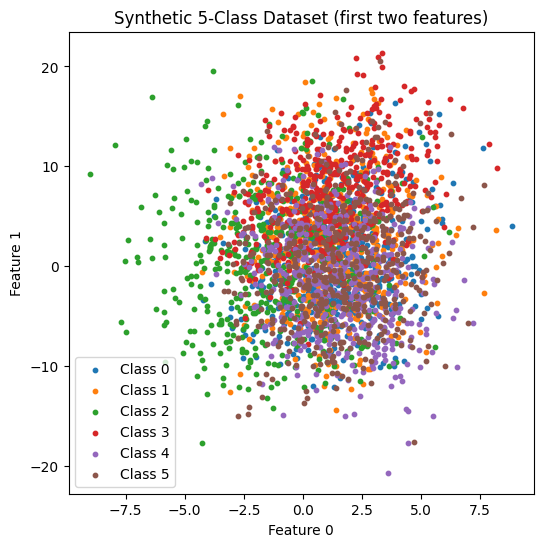

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

np.random.seed(42)

X, y = make_classification(
    n_samples=3000,
    n_features=20,
    n_informative=15,
    n_redundant=3,
    n_classes=6,
    n_clusters_per_class=1,
    class_sep=1.5,
    random_state=42
)

print("X shape:", X.shape)
print("y shape:", y.shape)

plt.figure(figsize=(6,6))
for cls in np.unique(y):
    plt.scatter(X[y==cls,0], X[y==cls,1], label=f"Class {cls}", s=10)
plt.legend()
plt.title("Synthetic 5-Class Dataset (first two features)")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

test_size = 0.3
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

ohe = OneHotEncoder(sparse_output=False)
y_train_oh = ohe.fit_transform(y_train.reshape(-1,1))
y_test_oh  = ohe.transform(y_test.reshape(-1,1))

print("Train samples:", X_train.shape[0], "Test samples:", X_test.shape[0])
print("One-hot shape:", y_train_oh.shape)

Train samples: 2100 Test samples: 900
One-hot shape: (2100, 6)


In [22]:
class NeuralNetwork:
    def __init__(self, input_dim, h1, h2, h3, output_dim, learning_rate=0.01, seed=42):
        np.random.seed(seed)
        self.lr = learning_rate

        def glorot_init(in_dim, out_dim):
            limit = np.sqrt(6.0 / (in_dim + out_dim))
            return np.random.uniform(-limit, limit, size=(in_dim, out_dim))

        self.W1 = glorot_init(input_dim, h1)
        self.b1 = np.zeros((1, h1))
        self.W2 = glorot_init(h1, h2)
        self.b2 = np.zeros((1, h2))
        self.W3 = glorot_init(h2, h3)
        self.b3 = np.zeros((1, h3))
        self.W4 = glorot_init(h3, output_dim)
        self.b4 = np.zeros((1, output_dim))

    @staticmethod
    def relu(x):
        return np.maximum(0, x)
    @staticmethod
    def drelu(x):
        return (x > 0).astype(float)

    @staticmethod
    def softmax(z):
        z_shift = z - np.max(z, axis=1, keepdims=True)
        exp = np.exp(z_shift)
        return exp / np.sum(exp, axis=1, keepdims=True)

    @staticmethod
    def cross_entropy_loss(y_true_oh, y_pred_prob):
        eps = 1e-12
        probs = np.clip(y_pred_prob, eps, 1. - eps)
        return -np.mean(np.sum(y_true_oh * np.log(probs), axis=1))

    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.relu(self.Z2)
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = self.relu(self.Z3)
        self.Z4 = np.dot(self.A3, self.W4) + self.b4
        self.A4 = self.softmax(self.Z4)
        return self.A4

    def backward(self, X, y_true_oh, y_pred):
        m = X.shape[0]
        dZ4 = (y_pred - y_true_oh) / m
        dW4 = np.dot(self.A3.T, dZ4)
        db4 = np.sum(dZ4, axis=0, keepdims=True)

        dA3 = np.dot(dZ4, self.W4.T)
        dZ3 = dA3 * self.drelu(self.Z3)
        dW3 = np.dot(self.A2.T, dZ3)
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * self.drelu(self.Z2)
        dW2 = np.dot(self.A1.T, dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.drelu(self.Z1)
        dW1 = np.dot(X.T, dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        self.W4 -= self.lr * dW4
        self.b4 -= self.lr * db4
        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def train(self, X, y_true_oh, X_val=None, y_val_oh=None, epochs=100, batch_size=None, verbose=True):
        history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}
        n = X.shape[0]
        for epoch in range(1, epochs+1):
            idx = np.random.permutation(n)
            X_sh, y_sh = X[idx], y_true_oh[idx]

            if batch_size is None:
                y_pred = self.forward(X_sh)
                loss = self.cross_entropy_loss(y_sh, y_pred)
                self.backward(X_sh, y_sh, y_pred)
            else:
                loss_accum = 0.0
                for i in range(0, n, batch_size):
                    xb = X_sh[i:i+batch_size]
                    yb = y_sh[i:i+batch_size]
                    y_pred_b = self.forward(xb)
                    loss_accum += self.cross_entropy_loss(yb, y_pred_b) * xb.shape[0]
                    self.backward(xb, yb, y_pred_b)
                loss = loss_accum / n

            preds_train = np.argmax(self.forward(X), axis=1)
            acc_train = np.mean(preds_train == np.argmax(y_true_oh, axis=1))

            if X_val is not None and y_val_oh is not None:
                preds_val_prob = self.forward(X_val)
                loss_val = self.cross_entropy_loss(y_val_oh, preds_val_prob)
                preds_val = np.argmax(preds_val_prob, axis=1)
                acc_val = np.mean(preds_val == np.argmax(y_val_oh, axis=1))
            else:
                loss_val = None
                acc_val = None

            history['loss'].append(loss)
            history['val_loss'].append(loss_val)
            history['acc'].append(acc_train)
            history['val_acc'].append(acc_val)

            if verbose and (epoch % max(1, epochs//10) == 0 or epoch==1):
                if loss_val is None:
                    print(f"Epoch {epoch}/{epochs} — loss: {loss:.4f}, acc: {acc_train:.4f}")
                else:
                    print(f"Epoch {epoch}/{epochs} — loss: {loss:.4f}, acc: {acc_train:.4f}, val_loss: {loss_val:.4f}, val_acc: {acc_val:.4f}")
        return history

    def predict_proba(self, X):
        return self.forward(X)
    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)


Epoch 1/120 — loss: 1.7628, acc: 0.3126, val_loss: 1.7051, val_acc: 0.2794
Epoch 12/120 — loss: 0.4749, acc: 0.8852, val_loss: 0.4486, val_acc: 0.8794
Epoch 24/120 — loss: 0.2633, acc: 0.9272, val_loss: 0.3029, val_acc: 0.9048
Epoch 36/120 — loss: 0.2061, acc: 0.9457, val_loss: 0.2732, val_acc: 0.9238
Epoch 48/120 — loss: 0.1705, acc: 0.9597, val_loss: 0.2533, val_acc: 0.9302
Epoch 60/120 — loss: 0.1452, acc: 0.9669, val_loss: 0.2424, val_acc: 0.9365
Epoch 72/120 — loss: 0.1242, acc: 0.9754, val_loss: 0.2354, val_acc: 0.9460
Epoch 84/120 — loss: 0.1067, acc: 0.9793, val_loss: 0.2322, val_acc: 0.9460
Epoch 96/120 — loss: 0.0919, acc: 0.9838, val_loss: 0.2265, val_acc: 0.9492
Epoch 108/120 — loss: 0.0791, acc: 0.9877, val_loss: 0.2230, val_acc: 0.9492
Epoch 120/120 — loss: 0.0679, acc: 0.9894, val_loss: 0.2196, val_acc: 0.9492


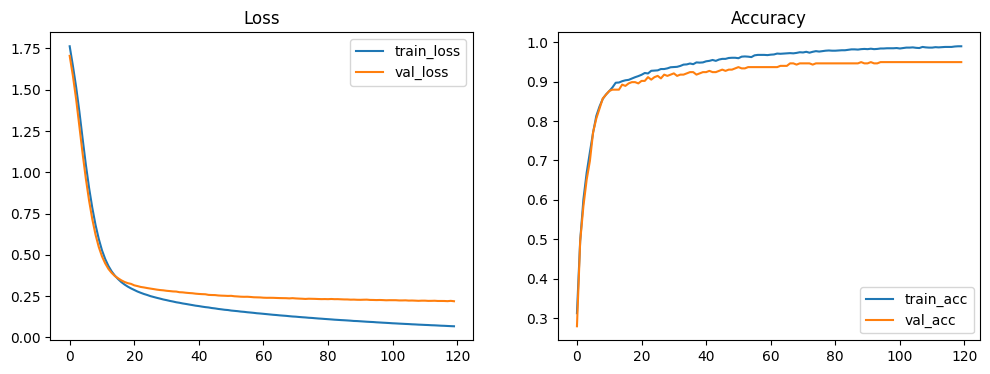

In [23]:
input_dim = X_train.shape[1]
h1, h2, h3 = 64, 64, 32
output_dim = y_train_oh.shape[1]

X_tr, X_val, y_tr_oh, y_val_oh = train_test_split(X_train, y_train_oh, test_size=0.15, random_state=42, stratify=y_train)

nn = NeuralNetwork(input_dim=input_dim, h1=h1, h2=h2, h3=h3, output_dim=output_dim, learning_rate=0.01, seed=42)

history = nn.train(X_tr, y_tr_oh, X_val=X_val, y_val_oh=y_val_oh, epochs=120, batch_size=32, verbose=True)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='train_loss')
if history['val_loss'][0] is not None:
    plt.plot(history['val_loss'], label='val_loss')
plt.title("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history['acc'], label='train_acc')
if history['val_acc'][0] is not None:
    plt.plot(history['val_acc'], label='val_acc')
plt.title("Accuracy")
plt.legend()
plt.show()


In [24]:

y_test_prob = nn.predict_proba(X_test)


n_show = 8
indices = np.random.choice(len(X_test), n_show, replace=False)

for i, idx in enumerate(indices):
    probs = y_test_prob[idx]
    top5_idx = np.argsort(probs)[::-1][:5]

    print(f"Sample {i+1} (True class = {y_test[idx]}):")
    for rank, cls_id in enumerate(top5_idx, start=1):
        print(f"   Rank {rank}: class={cls_id}, prob={probs[cls_id]:.4f}")
    print("-"*40)

Sample 1 (True class = 2):
   Rank 1: class=2, prob=0.9922
   Rank 2: class=3, prob=0.0074
   Rank 3: class=0, prob=0.0003
   Rank 4: class=1, prob=0.0000
   Rank 5: class=5, prob=0.0000
----------------------------------------
Sample 2 (True class = 2):
   Rank 1: class=2, prob=0.9999
   Rank 2: class=3, prob=0.0001
   Rank 3: class=0, prob=0.0000
   Rank 4: class=1, prob=0.0000
   Rank 5: class=5, prob=0.0000
----------------------------------------
Sample 3 (True class = 4):
   Rank 1: class=4, prob=0.9911
   Rank 2: class=2, prob=0.0066
   Rank 3: class=3, prob=0.0016
   Rank 4: class=1, prob=0.0006
   Rank 5: class=0, prob=0.0000
----------------------------------------
Sample 4 (True class = 3):
   Rank 1: class=3, prob=0.9970
   Rank 2: class=0, prob=0.0022
   Rank 3: class=2, prob=0.0005
   Rank 4: class=1, prob=0.0002
   Rank 5: class=4, prob=0.0001
----------------------------------------
Sample 5 (True class = 2):
   Rank 1: class=2, prob=0.9982
   Rank 2: class=1, prob=0.00

In [25]:

y_test_pred = nn.predict(X_test)

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

y_pred_classes = y_test_pred

print("Precision :", precision_score(y_test, y_pred_classes, average='macro'))
print("Recall :   ", recall_score(y_test, y_pred_classes, average='macro'))
print("F1-score : ", f1_score(y_test, y_pred_classes, average='macro'))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

Precision : 0.950784002990576
Recall :    0.9499681109933671
F1-score :  0.9499542226659193

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       150
           1       0.96      0.98      0.97       150
           2       0.97      0.95      0.96       152
           3       0.98      0.97      0.98       149
           4       0.90      0.97      0.94       150
           5       0.92      0.91      0.92       149

    accuracy                           0.95       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.95      0.95      0.95       900



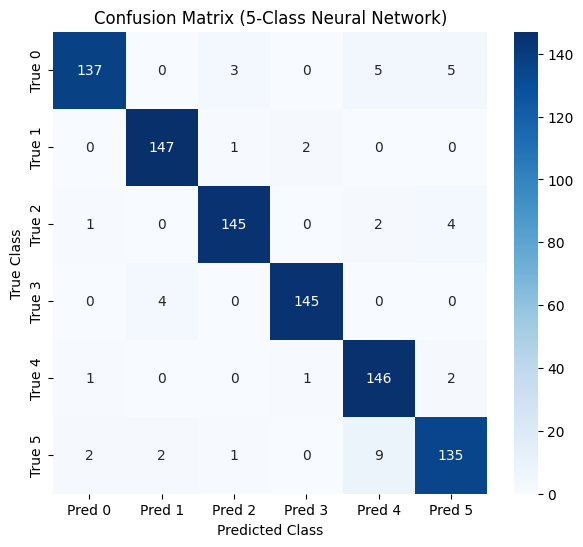

<Figure size 640x480 with 0 Axes>

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Pred {i}' for i in range(cm.shape[0])],
            yticklabels=[f'True {i}' for i in range(cm.shape[0])])
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix (5-Class Neural Network)")
plt.show()
plt.tight_layout()
plt.show(block=True)
%matplotlib inline


In [27]:

n_samples = X.shape[0]
n_features = X.shape[1]
n_classes = len(np.unique(y))


total_params = (
    input_dim*h1 + h1 +      # W1 + b1
    h1*h2 + h2 +             # W2 + b2
    h2*h3 + h3 +             # W3 + b3
    h3*output_dim + output_dim  # W4 + b4
)

epochs = 120
learning_rate = nn.lr

train_accuracy = history['acc'][-1]
val_accuracy   = history['val_acc'][-1]
test_accuracy  = accuracy_score(y_test, y_test_pred)

# Precision, recall, F1
precision_macro = precision_score(y_test, y_test_pred, average='macro')
recall_macro    = recall_score(y_test, y_test_pred, average='macro')
f1_macro        = f1_score(y_test, y_test_pred, average='macro')

print("DATASET INFORMATION ")
print(f"  • Total samples:       {n_samples}")
print(f"  • Features:            {n_features}")
print(f"  • Classes:             {n_classes}")
print(f"  • Training samples:    {X_train.shape[0]}")
print(f"  • Testing samples:     {X_test.shape[0]}")

print("MODEL ARCHITECTURE")
print(f"  • Input layer:         {input_dim} neurons")
print(f"  • Hidden layer 1:      {h1} neurons")
print(f"  • Hidden layer 2:      {h2} neurons")
print(f"  • Hidden layer 3:      {h3} neurons")
print(f"  • Output layer:        {output_dim} neurons")
print(f"  • Total parameters:    {total_params}")

print("TRAINING CONFIGURATION ")
print(f"  • Epochs:              {epochs}")
print(f"  • Learning rate:       {learning_rate}")
print(f"  • Activation (hidden): ReLU")
print(f"  • Activation (output): Softmax")
print(f"  • Loss function:       Cross-Entropy")
print(f"  • Batch size:          32")

print(" FINAL PERFORMANCE")
print(f"  • Training accuracy:   {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  • Validation accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"  • Testing accuracy:    {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  • Avg Precision:       {precision_macro:.4f}")
print(f"  • Avg Recall:          {recall_macro:.4f}")
print(f"  • Avg F1-score:        {f1_macro:.4f}")

DATASET INFORMATION 
  • Total samples:       3000
  • Features:            20
  • Classes:             6
  • Training samples:    2100
  • Testing samples:     900
MODEL ARCHITECTURE
  • Input layer:         20 neurons
  • Hidden layer 1:      64 neurons
  • Hidden layer 2:      64 neurons
  • Hidden layer 3:      32 neurons
  • Output layer:        6 neurons
  • Total parameters:    7782
TRAINING CONFIGURATION 
  • Epochs:              120
  • Learning rate:       0.01
  • Activation (hidden): ReLU
  • Activation (output): Softmax
  • Loss function:       Cross-Entropy
  • Batch size:          32
 FINAL PERFORMANCE
  • Training accuracy:   0.9894 (98.94%)
  • Validation accuracy: 0.9492 (94.92%)
  • Testing accuracy:    0.9500 (95.00%)
  • Avg Precision:       0.9508
  • Avg Recall:          0.9500
  • Avg F1-score:        0.9500


In [31]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle
n_classes = y_test_oh.shape[1]  # 6 classes

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_oh[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


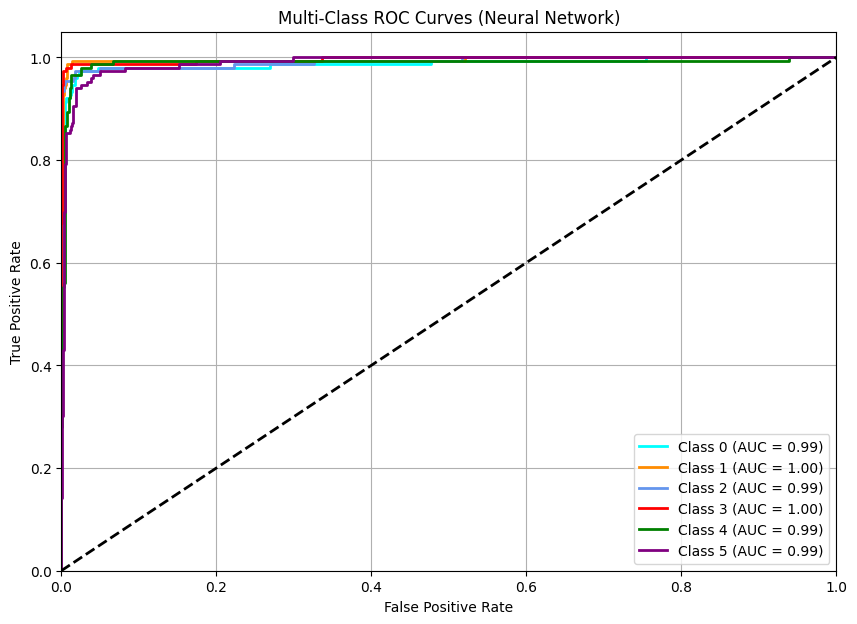

In [32]:
plt.figure(figsize=(10,7))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:0.2f})")

plt.plot([0,1], [0,1], 'k--', lw=2)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curves (Neural Network)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [33]:
# Micro-average
roc_auc_micro = roc_auc_score(y_test_oh, y_test_prob, average='micro')
# Macro-average
roc_auc_macro = roc_auc_score(y_test_oh, y_test_prob, average='macro')

print(f"Micro-average AUC: {roc_auc_micro:.4f}")
print(f"Macro-average AUC: {roc_auc_macro:.4f}")

Micro-average AUC: 0.9918
Macro-average AUC: 0.9918
